In [1]:
import pandas as pd

df = pd.read_excel("Table S1.xlsx")

In [2]:
df.replace('-', None, inplace=True)
df.replace('na', None, inplace=True)
df.replace('unknown', None, inplace=True)

In [3]:
df

,No,Family ID,Pedigree ID (informative individuals),Age,Sex,ET status,PD status,Clinical Assesment,ET Severity,Age of ET Onset,Onset,Status,Relationship,Listing Criteria
0,1,Family-1,I-1,75,male,no,no,no,None,None,None,deceased,m-grandfather,children have ET
1,2,Family-1,I-2,80,female,yes,no,no,severe,61,late,deceased,m-grandmother,ET
2,3,Family-1,II-1,79,female,yes,no,yes,severe,30,intermediate,deceased,mother,ET
3,4,Family-1,II-2,70,male,no,no,no,None,None,None,deceased,father,husband and son have ET
4,5,Family-1,II-3,92,female,yes,no,no,severe,60,late,deceased,m-aunt,ET
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1488,1489,Family-161,IV-5,54,male,yes,no,no,mild,35-40,intermediate,alive,uncle,ET
1489,1490,Family-161,IV-6,48,male,yes,no,no,mild,35-40,intermediate,alive,father,ET
1490,1491,Family-161,IV-7,48,male,yes,no,no,mild,15-16,intermediate,alive,mother,ET
1491,1492,Family-161,IV-8,43,male,yes,no,no,mild,15-16,intermediate,alive,uncle,ET


In [4]:
min(df["Age"])

40

In [5]:
df["Sex"].value_counts()

Sex
female    760
male      733
Name: count, dtype: int64

In [6]:
df["ET status"].value_counts()

ET status
no     751
yes    742
Name: count, dtype: int64

In [7]:
df["PD status"].value_counts()

PD status
no     1450
yes      43
Name: count, dtype: int64

In [8]:
df["Clinical Assesment"].value_counts()

Clinical Assesment
no     1158
yes     334
Name: count, dtype: int64

In [9]:
df["ET Severity"].value_counts()

ET Severity
severe      493
mild        144
moderate    100
Name: count, dtype: int64

In [10]:
df["Onset"].value_counts()

Onset
intermediate    236
late            149
early           114
Name: count, dtype: int64

In [11]:
df["Status"].value_counts()

Status
alive       895
deceased    598
Name: count, dtype: int64

In [12]:
df['survival_event'] = df['Status'].apply(lambda x: 1 if x == 'deceased' else 0)

In [13]:
df

,No,Family ID,Pedigree ID (informative individuals),Age,Sex,ET status,PD status,Clinical Assesment,ET Severity,Age of ET Onset,Onset,Status,Relationship,Listing Criteria,survival_event
0,1,Family-1,I-1,75,male,no,no,no,None,None,None,deceased,m-grandfather,children have ET,1
1,2,Family-1,I-2,80,female,yes,no,no,severe,61,late,deceased,m-grandmother,ET,1
2,3,Family-1,II-1,79,female,yes,no,yes,severe,30,intermediate,deceased,mother,ET,1
3,4,Family-1,II-2,70,male,no,no,no,None,None,None,deceased,father,husband and son have ET,1
4,5,Family-1,II-3,92,female,yes,no,no,severe,60,late,deceased,m-aunt,ET,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1488,1489,Family-161,IV-5,54,male,yes,no,no,mild,35-40,intermediate,alive,uncle,ET,0
1489,1490,Family-161,IV-6,48,male,yes,no,no,mild,35-40,intermediate,alive,father,ET,0
1490,1491,Family-161,IV-7,48,male,yes,no,no,mild,15-16,intermediate,alive,mother,ET,0
1491,1492,Family-161,IV-8,43,male,yes,no,no,mild,15-16,intermediate,alive,uncle,ET,0


In [14]:
survival_df = df[["Age","Sex","ET status","survival_event"]]
survival_df

,Age,Sex,ET status,survival_event
0,75,male,no,1
1,80,female,yes,1
2,79,female,yes,1
3,70,male,no,1
4,92,female,yes,1
...,...,...,...,...
1488,54,male,yes,0
1489,48,male,yes,0
1490,48,male,yes,0
1491,43,male,yes,0


In [15]:
survival_df['ET status'] = survival_df['ET status'].map({'yes': 1, 'no': 0})
survival_df['Sex'] = survival_df['Sex'].map({'female': 1, 'male': 2})

/var/folders/jw/lmwzphvs71n8yhl1t4k30tzr0000gn/T/ipykernel_10811/3831648739.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  survival_df['ET status'] = survival_df['ET status'].map({'yes': 1, 'no': 0})
/var/folders/jw/lmwzphvs71n8yhl1t4k30tzr0000gn/T/ipykernel_10811/3831648739.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  survival_df['Sex'] = survival_df['Sex'].map({'female': 1, 'male': 2})


In [16]:
survival_df

,Age,Sex,ET status,survival_event
0,75,2,0,1
1,80,1,1,1
2,79,1,1,1
3,70,2,0,1
4,92,1,1,1
...,...,...,...,...
1488,54,2,1,0
1489,48,2,1,0
1490,48,2,1,0
1491,43,2,1,0


In [17]:
from lifelines.statistics import logrank_test
results = logrank_test(survival_df[survival_df["ET status"] == 0]["Age"],
                       survival_df[survival_df["ET status"] == 1]["Age"], 
                       event_observed_A=survival_df[survival_df["ET status"] == 0]["survival_event"], 
                       event_observed_B=survival_df[survival_df["ET status"] == 1]["survival_event"])

results.print_summary()
print(results.p_value)       
print(results.test_statistic) 

<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
         100.64 <0.005     76.26

1.1055123406490687e-23
100.63580314915303


In [18]:
from lifelines import CoxPHFitter

cph = CoxPHFitter()
cph.fit(survival_df[["Age","survival_event","ET status"]], duration_col='Age', event_col='survival_event')
cph.print_summary()

<lifelines.CoxPHFitter: fitted with 1493 total observations, 895 right-censored observations>
             duration col = 'Age'
                event col = 'survival_event'
      baseline estimation = breslow
   number of observations = 1493
number of events observed = 598
   partial log-likelihood = -3495.69
         time fit was run = 2024-05-10 12:58:13 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
ET status  -0.82       0.44       0.09            -0.99            -0.65                 0.37                 0.52

            cmp to     z      p   -log2(p)
covariate                                 
ET status     0.00 -9.64 <0.005      70.65
---
Concordance = 0.63
Partial AIC = 6993.37
log-likelihood ratio test = 93.99 on 1 df
-log2(p) of ll-ratio test = 71.42

In [19]:
hr = cph.hazard_ratios_
hr_sum = cph.summary
print(hr[0],hr_sum)

0.4397650541930304                coef  exp(coef)  se(coef)  coef lower 95%  coef upper 95%  \
covariate                                                                  
ET status -0.821515   0.439765  0.085218       -0.988538       -0.654491   

           exp(coef) lower 95%  exp(coef) upper 95%  cmp to         z  \
covariate                                                               
ET status              0.37212             0.519706     0.0 -9.640208   

                      p   -log2(p)  
covariate                           
ET status  5.407836e-22  70.647367  


/var/folders/jw/lmwzphvs71n8yhl1t4k30tzr0000gn/T/ipykernel_10811/1775232013.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(hr[0],hr_sum)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/var/folders/jw/lmwzphvs71n8yhl1t4k30tzr0000gn/T/ipykernel_10811/4240202419.py:70: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  f"HR : {round(hr[0],ndigits=2)}, $CI_{{95\%}}:$[{round(hr_sum.loc['ET status', 'exp(coef) lower 95%'],ndigits=2)},{round(hr_sum.loc['ET status', 'exp(coef) upper 95%'],ndigits=2)}]",


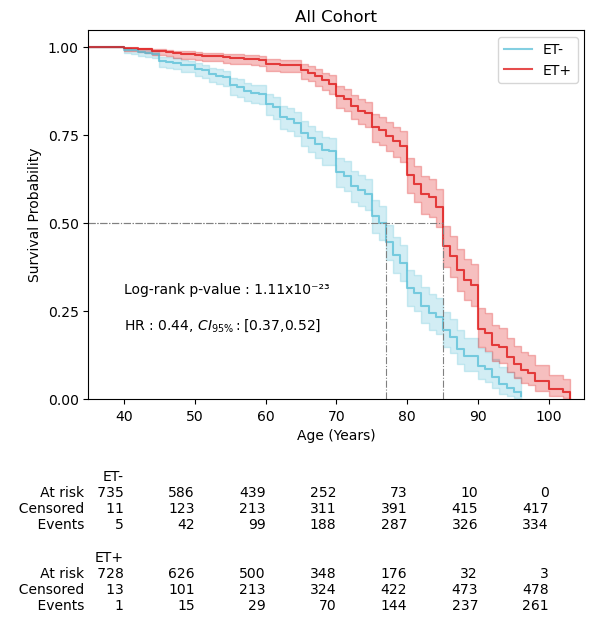

In [20]:
from lifelines import KaplanMeierFitter
from lifelines.plotting import add_at_risk_counts
from lifelines.statistics import logrank_test
import unicodeit
import numpy as np
import matplotlib.pyplot as plt

ax = plt.subplot(111)

plt.xticks(range(0, max(df["Age"]) + 10, 10))

y_ticks = [0] + [i * 0.25 for i in range(1, 5)]
plt.yticks(y_ticks)

plt.xlim([35, 105])
plt.ylim([0, 1.05])

plt.title("All Cohort")
#plt.xlabel("Age (Years)")
plt.ylabel("Survival Probability")
plt.legend(loc='best')

kmf_no = KaplanMeierFitter()
ax = kmf_no.fit(survival_df[survival_df["ET status"] == 0]["Age"],
                survival_df[survival_df["ET status"] == 0]["survival_event"], 
                label='ET-').plot_survival_function(ax=ax,color="#4DBBD5B2")

kmf_yes = KaplanMeierFitter()
ax = kmf_yes.fit(survival_df[survival_df["ET status"] == 1]["Age"],
                 survival_df[survival_df["ET status"] == 1]["survival_event"], 
                 label='ET+').plot_survival_function(ax=ax,color="#DC0000B2")

add_at_risk_counts(kmf_no, kmf_yes, ax=ax)

# Calculate and annotate median survival times
median_survival_et = kmf_yes.median_survival_time_
median_survival_non_et = kmf_no.median_survival_time_

ax.axhline(y=0.5,xmax=0.52 ,linestyle='-.', color='grey', linewidth=0.8, label='Median')
ax.axvline(x=77,ymax=0.48, linestyle='-.', color='grey', linewidth=0.8, label='Median')

ax.axhline(y=0.5,xmax=0.715 ,linestyle='-.', color='grey', linewidth=0.8, label='Median')
ax.axvline(x=85,ymax=0.48, linestyle='-.', color='grey', linewidth=0.8, label='Median')


results = logrank_test(survival_df[survival_df["ET status"] == 0]["Age"],
                       survival_df[survival_df["ET status"] == 1]["Age"], 
                       event_observed_A=survival_df[survival_df["ET status"] == 0]["survival_event"], 
                       event_observed_B=survival_df[survival_df["ET status"] == 1]["survival_event"])

number = results.p_value
exponent = int(np.floor(np.log10(np.abs(number))))
# Calculate the significand (x)
significand = number / 10**exponent
significand = round(significand,ndigits=2)
sign = '-' if exponent < 0 else ''  # Determine the sign
digits = [int(digit) for digit in str(abs(exponent))]  # Get individual digits as integers
logrank_p_value = unicodeit.replace(f"{significand}x10^{sign}^{digits[0]}^{digits[1]}")

plt.text(40, 0.3, f"Log-rank p-value : {logrank_p_value}", fontsize=10)

from lifelines import CoxPHFitter

cph = CoxPHFitter()
cph.fit(survival_df[["Age","survival_event","ET status"]], duration_col='Age', event_col='survival_event')
hr = cph.hazard_ratios_
hr_sum = cph.summary

plt.text(40, 0.2, 
         f"HR : {round(hr[0],ndigits=2)}, $CI_{{95\%}}:$[{round(hr_sum.loc['ET status', 'exp(coef) lower 95%'],ndigits=2)},{round(hr_sum.loc['ET status', 'exp(coef) upper 95%'],ndigits=2)}]", 
         fontsize=10)

ax.set_xlabel("Age (Years)")

plt.show()

In [21]:
kmf_no.median_survival_time_

77.0

In [22]:
kmf_yes.median_survival_time_

85.0

In [23]:
et_positive_df = survival_df[survival_df["ET status"]==1]
et_negative_df = survival_df[survival_df["ET status"]==0]
female_df = survival_df[survival_df["Sex"]==1]
male_df = survival_df[survival_df["Sex"]==2]

In [24]:
from lifelines.statistics import logrank_test
results = logrank_test(et_positive_df[et_positive_df["Sex"] == 1]["Age"],
                       et_positive_df[et_positive_df["Sex"] == 2]["Age"], 
                       event_observed_A=et_positive_df[et_positive_df["Sex"] == 1]["survival_event"], 
                       event_observed_B=et_positive_df[et_positive_df["Sex"] == 2]["survival_event"])

results.print_summary()
print(results.p_value)       
print(results.test_statistic) 

<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic    p  -log2(p)
           3.72 0.05      4.22

0.053690045783702754
3.7223099540617146


In [25]:
round(results.p_value,ndigits=3)

0.054

In [26]:
et_positive_df

,Age,Sex,ET status,survival_event
1,80,1,1,1
2,79,1,1,1
4,92,1,1,1
5,87,2,1,0
7,72,2,1,1
...,...,...,...,...
1488,54,2,1,0
1489,48,2,1,0
1490,48,2,1,0
1491,43,2,1,0


In [27]:
et_positive_cox = et_positive_df
et_positive_cox = et_positive_cox.drop("ET status",axis=1)
et_positive_cox

,Age,Sex,survival_event
1,80,1,1
2,79,1,1
4,92,1,1
5,87,2,0
7,72,2,1
...,...,...,...
1488,54,2,0
1489,48,2,0
1490,48,2,0
1491,43,2,0


In [28]:
from lifelines import CoxPHFitter

cph = CoxPHFitter()
cph.fit(et_positive_cox, duration_col='Age', event_col='survival_event')
cph.print_summary()

<lifelines.CoxPHFitter: fitted with 742 total observations, 478 right-censored observations>
             duration col = 'Age'
                event col = 'survival_event'
      baseline estimation = breslow
   number of observations = 742
number of events observed = 264
   partial log-likelihood = -1326.70
         time fit was run = 2024-05-10 12:58:14 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
Sex         0.24       1.28       0.12             0.00             0.49                 1.00                 1.63

            cmp to    z    p   -log2(p)
covariate                              
Sex           0.00 1.96 0.05       4.32
---
Concordance = 0.55
Partial AIC = 2655.40
log-likelihood ratio test = 3.84 on 1 df
-log2(p) of ll-ratio test = 4.32

In [29]:
hr = cph.hazard_ratios_
hr_sum = cph.summary
print(hr[0],hr_sum)

1.276059283936398                coef  exp(coef)  se(coef)  coef lower 95%  coef upper 95%  \
covariate                                                                  
Sex        0.243777   1.276059  0.124333        0.000089        0.487465   

           exp(coef) lower 95%  exp(coef) upper 95%  cmp to         z  \
covariate                                                               
Sex                   1.000089             1.628183     0.0  1.960677   

                  p  -log2(p)  
covariate                      
Sex        0.049917  4.324334  


/var/folders/jw/lmwzphvs71n8yhl1t4k30tzr0000gn/T/ipykernel_10811/1775232013.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(hr[0],hr_sum)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/var/folders/jw/lmwzphvs71n8yhl1t4k30tzr0000gn/T/ipykernel_10811/3898506955.py:64: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  f"HR : {round(hr[0],ndigits=2)}, $CI_{{95\%}}:$[{round(hr_sum.loc['Sex', 'exp(coef) lower 95%'],ndigits=2)},{round(hr_sum.loc['Sex', 'exp(coef) upper 95%'],ndigits=2)}]",


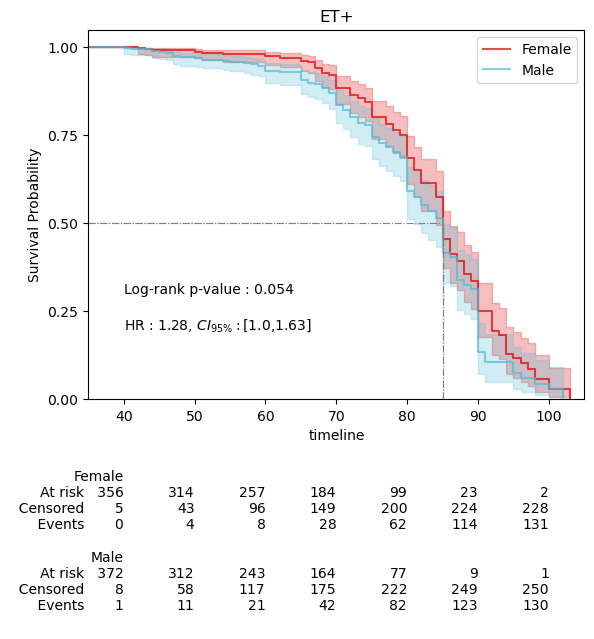

In [30]:
from lifelines import KaplanMeierFitter
from lifelines.plotting import add_at_risk_counts
from lifelines.statistics import logrank_test
import unicodeit
import numpy as np
import matplotlib.pyplot as plt

ax = plt.subplot(111)

plt.xticks(range(0, max(df["Age"]) + 10, 10))

y_ticks = [0] + [i * 0.25 for i in range(1, 5)]
plt.yticks(y_ticks)

plt.xlim([35, 105])
plt.ylim([0, 1.05])

plt.title("ET+")
plt.xlabel("Age (Years)")
plt.ylabel("Survival Probability")
plt.legend(loc='best')

kmf_female = KaplanMeierFitter()
ax = kmf_female.fit(et_positive_df[et_positive_df["Sex"] == 1]["Age"],
                et_positive_df[et_positive_df["Sex"] == 1]["survival_event"], 
                label='Female').plot_survival_function(ax=ax,color="#DC0000B2")

kmf_male = KaplanMeierFitter()
ax = kmf_male.fit(et_positive_df[et_positive_df["Sex"] == 2]["Age"],
                 et_positive_df[et_positive_df["Sex"] == 2]["survival_event"], 
                 label='Male').plot_survival_function(ax=ax,color="#4DBBD5B2")

add_at_risk_counts(kmf_female, kmf_male, ax=ax)

# Calculate and annotate median survival times
median_survival_female = kmf_female.median_survival_time_
median_survival_male = kmf_male.median_survival_time_

ax.axhline(y=0.5,xmax=0.52 ,linestyle='-.', color='grey', linewidth=0.8, label='Median')
ax.axvline(x=85,ymax=0.48, linestyle='-.', color='grey', linewidth=0.8, label='Median')

ax.axhline(y=0.5,xmax=0.71 ,linestyle='-.', color='grey', linewidth=0.8, label='Median')
ax.axvline(x=85,ymax=0.48, linestyle='-.', color='grey', linewidth=0.8, label='Median')


results = logrank_test(et_positive_df[et_positive_df["Sex"] == 1]["Age"],
                       et_positive_df[et_positive_df["Sex"] == 2]["Age"], 
                       event_observed_A=et_positive_df[et_positive_df["Sex"] == 1]["survival_event"], 
                       event_observed_B=et_positive_df[et_positive_df["Sex"] == 2]["survival_event"])


logrank_p_value = round(results.p_value,ndigits=3)

plt.text(40, 0.3, f"Log-rank p-value : {logrank_p_value}", fontsize=10)

from lifelines import CoxPHFitter

cph = CoxPHFitter()
cph.fit(et_positive_cox, duration_col='Age', event_col='survival_event')
hr = cph.hazard_ratios_
hr_sum = cph.summary

plt.text(40, 0.2, 
         f"HR : {round(hr[0],ndigits=2)}, $CI_{{95\%}}:$[{round(hr_sum.loc['Sex', 'exp(coef) lower 95%'],ndigits=2)},{round(hr_sum.loc['Sex', 'exp(coef) upper 95%'],ndigits=2)}]", 
         fontsize=10)

plt.show()

In [31]:
median_survival_female

85.0

In [32]:
median_survival_male

85.0

In [33]:
from lifelines.statistics import logrank_test
results = logrank_test(et_negative_df[et_negative_df["Sex"] == 1]["Age"],
                       et_negative_df[et_negative_df["Sex"] == 2]["Age"], 
                       event_observed_A=et_negative_df[et_negative_df["Sex"] == 1]["survival_event"], 
                       event_observed_B=et_negative_df[et_negative_df["Sex"] == 2]["survival_event"])

results.print_summary()
print(results.p_value)       
print(results.test_statistic) 

<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
          16.93 <0.005     14.65

3.883857109563783e-05
16.927319758905373


In [34]:
number = results.p_value
exponent = int(np.floor(np.log10(np.abs(number))))
# Calculate the significand (x)
significand = number / 10**exponent
significand = round(significand,ndigits=2)
sign = '-' if exponent < 0 else ''  # Determine the sign
digits = [int(digit) for digit in str(abs(exponent))]  # Get individual digits as integers
logrank_p_value = unicodeit.replace(f"{significand}x10^{sign}^{digits[0]}")
logrank_p_value

'3.88x10⁻⁵'

In [35]:
from lifelines import CoxPHFitter

cph = CoxPHFitter()
cph.fit(et_negative_df[["Age","Sex","survival_event"]], duration_col='Age', event_col='survival_event')
cph.print_summary()

<lifelines.CoxPHFitter: fitted with 751 total observations, 417 right-censored observations>
             duration col = 'Age'
                event col = 'survival_event'
      baseline estimation = breslow
   number of observations = 751
number of events observed = 334
   partial log-likelihood = -1789.71
         time fit was run = 2024-05-10 12:58:14 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
Sex         0.45       1.57       0.11             0.23             0.67                 1.26                 1.95

            cmp to    z      p   -log2(p)
covariate                                
Sex           0.00 4.08 <0.005      14.44
---
Concordance = 0.56
Partial AIC = 3581.43
log-likelihood ratio test = 16.72 on 1 df
-log2(p) of ll-ratio test = 14.50

In [36]:
hr = cph.hazard_ratios_
hr_sum = cph.summary
print(hr[0],hr_sum)

1.570256207954177                coef  exp(coef)  se(coef)  coef lower 95%  coef upper 95%  \
covariate                                                                  
Sex        0.451239   1.570256  0.110601        0.234466        0.668012   

           exp(coef) lower 95%  exp(coef) upper 95%  cmp to         z  \
covariate                                                               
Sex                   1.264233             1.950356     0.0  4.079897   

                  p   -log2(p)  
covariate                       
Sex        0.000045  14.437933  


/var/folders/jw/lmwzphvs71n8yhl1t4k30tzr0000gn/T/ipykernel_10811/1775232013.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(hr[0],hr_sum)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/var/folders/jw/lmwzphvs71n8yhl1t4k30tzr0000gn/T/ipykernel_10811/289744200.py:65: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  f"HR : {round(hr[0],ndigits=2)}, $CI_{{95\%}}:$[{round(hr_sum.loc['Sex', 'exp(coef) lower 95%'],ndigits=2)},{round(hr_sum.loc['Sex', 'exp(coef) upper 95%'],ndigits=2)}]",


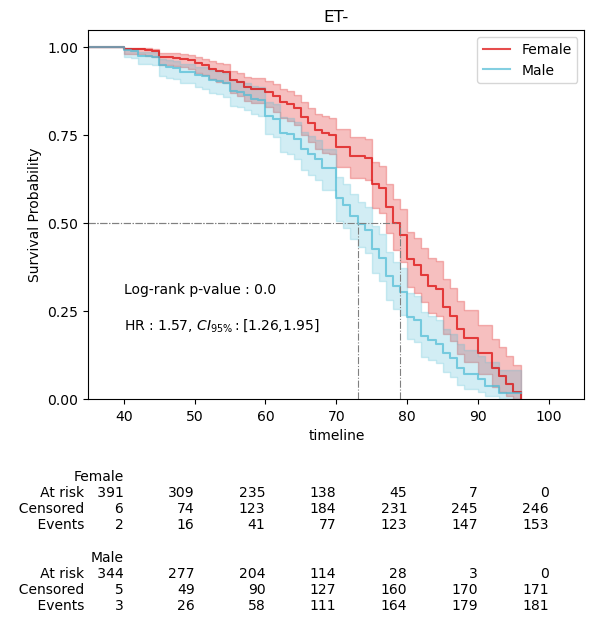

In [37]:
from lifelines import KaplanMeierFitter
from lifelines.plotting import add_at_risk_counts
from lifelines.statistics import logrank_test
from lifelines import CoxPHFitter
import unicodeit
import numpy as np
import matplotlib.pyplot as plt

ax = plt.subplot(111)

plt.xticks(range(0, max(df["Age"]) + 10, 10))

y_ticks = [0] + [i * 0.25 for i in range(1, 5)]
plt.yticks(y_ticks)

plt.xlim([35, 105])
plt.ylim([0, 1.05])

plt.title("ET-")
plt.xlabel("Age (Years)")
plt.ylabel("Survival Probability")
plt.legend(loc='best')

kmf_female = KaplanMeierFitter()
ax = kmf_female.fit(et_negative_df[et_negative_df["Sex"] == 1]["Age"],
                et_negative_df[et_negative_df["Sex"] == 1]["survival_event"], 
                label='Female').plot_survival_function(ax=ax,color="#DC0000B2")

kmf_male = KaplanMeierFitter()
ax = kmf_male.fit(et_negative_df[et_negative_df["Sex"] == 2]["Age"],
                 et_negative_df[et_negative_df["Sex"] == 2]["survival_event"], 
                 label='Male').plot_survival_function(ax=ax,color="#4DBBD5B2")

add_at_risk_counts(kmf_female, kmf_male, ax=ax)

# Calculate and annotate median survival times
median_survival_female = kmf_female.median_survival_time_
median_survival_male = kmf_male.median_survival_time_

ax.axhline(y=0.5,xmax=0.45 ,linestyle='-.', color='grey', linewidth=0.8, label='Median')
ax.axvline(x=79,ymax=0.48, linestyle='-.', color='grey', linewidth=0.8, label='Median')

ax.axhline(y=0.5,xmax=0.62 ,linestyle='-.', color='grey', linewidth=0.8, label='Median')
ax.axvline(x=73,ymax=0.48, linestyle='-.', color='grey', linewidth=0.8, label='Median')


results = logrank_test(et_negative_df[et_negative_df["Sex"] == 1]["Age"],
                       et_negative_df[et_negative_df["Sex"] == 2]["Age"], 
                       event_observed_A=et_negative_df[et_negative_df["Sex"] == 1]["survival_event"], 
                       event_observed_B=et_negative_df[et_negative_df["Sex"] == 2]["survival_event"])


logrank_p_value = round(results.p_value,ndigits=4)

plt.text(40, 0.3, f"Log-rank p-value : {logrank_p_value}", fontsize=10)



cph = CoxPHFitter()
cph.fit(et_negative_df[["Age","Sex","survival_event"]], duration_col='Age', event_col='survival_event')
hr = cph.hazard_ratios_
hr_sum = cph.summary

plt.text(40, 0.2, 
         f"HR : {round(hr[0],ndigits=2)}, $CI_{{95\%}}:$[{round(hr_sum.loc['Sex', 'exp(coef) lower 95%'],ndigits=2)},{round(hr_sum.loc['Sex', 'exp(coef) upper 95%'],ndigits=2)}]", 
         fontsize=10)

plt.show()

In [38]:
median_survival_female

79.0

In [39]:
median_survival_male

73.0

In [40]:
from lifelines.statistics import logrank_test
results = logrank_test(male_df[male_df["ET status"] == 1]["Age"],
                       male_df[male_df["ET status"] == 0]["Age"], 
                       event_observed_A=male_df[male_df["ET status"] == 1]["survival_event"], 
                       event_observed_B=male_df[male_df["ET status"] == 0]["survival_event"])

results.print_summary()
print(results.p_value)       
print(results.test_statistic) 

<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
          68.33 <0.005     52.68

1.384041746946189e-16
68.3285272948595


In [41]:
import pandas as pd

# Assuming df is your DataFrame
# Replace 'ET status' with the actual column name if it's different in your DataFrame

# Convert 'ET status' to categorical for better representation
survival_df['ET status'] = survival_df['ET status'].astype('category')

# Create dummy variables for 'ET status'
survival_df_dummies = pd.get_dummies(survival_df['ET status'], prefix='status',dtype="int")

# Concatenate the dummy variables with the original DataFrame
survival_df_expanded = pd.concat([survival_df, survival_df_dummies], axis=1)

# Drop the original 'ET status' column if you no longer need it
survival_df_expanded = survival_df_expanded.drop('ET status', axis=1)

# Print the expanded DataFrame
survival_df_expanded

/var/folders/jw/lmwzphvs71n8yhl1t4k30tzr0000gn/T/ipykernel_10811/3349428165.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  survival_df['ET status'] = survival_df['ET status'].astype('category')


,Age,Sex,survival_event,status_0,status_1
0,75,2,1,1,0
1,80,1,1,0,1
2,79,1,1,0,1
3,70,2,1,1,0
4,92,1,1,0,1
...,...,...,...,...,...
1488,54,2,0,0,1
1489,48,2,0,0,1
1490,48,2,0,0,1
1491,43,2,0,0,1


In [42]:
column_mapping = {"status_0":"No","status_1":"Yes"}

# Rename the columns using the dictionary
survival_df_expanded = survival_df_expanded.rename(columns=column_mapping)

In [43]:
survival_df_expanded # ET status yes ve no diye ayır o zaman multivariate olacak

,Age,Sex,survival_event,No,Yes
0,75,2,1,1,0
1,80,1,1,0,1
2,79,1,1,0,1
3,70,2,1,1,0
4,92,1,1,0,1
...,...,...,...,...,...
1488,54,2,0,0,1
1489,48,2,0,0,1
1490,48,2,0,0,1
1491,43,2,0,0,1


In [44]:
male_cox = survival_df_expanded[survival_df_expanded["Sex"]==2]
male_cox = male_cox.drop("Sex",axis=1)
male_cox

,Age,survival_event,No,Yes
0,75,1,1,0
3,70,1,1,0
5,87,0,0,1
7,72,1,0,1
8,81,1,0,1
...,...,...,...,...
1487,57,0,0,1
1488,54,0,0,1
1489,48,0,0,1
1490,48,0,0,1


In [45]:
from lifelines import CoxPHFitter

cph = CoxPHFitter(penalizer=0.1)
cph.fit(male_cox, duration_col='Age', event_col='survival_event',formula="Yes")
cph.print_summary()

<lifelines.CoxPHFitter: fitted with 733 total observations, 421 right-censored observations>
             duration col = 'Age'
                event col = 'survival_event'
                penalizer = 0.1
                 l1 ratio = 0.0
      baseline estimation = breslow
   number of observations = 733
number of events observed = 312
   partial log-likelihood = -1630.07
         time fit was run = 2024-05-10 12:58:14 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
Yes        -0.74       0.47       0.10            -0.95            -0.54                 0.39                 0.58

            cmp to     z      p   -log2(p)
covariate                                 
Yes           0.00 -7.10 <0.005      39.52
---
Concordance = 0.63
Partial AIC = 3262.14
log-likelihood ratio test = 50.43 on 1 df
-log2(p) of ll-ratio test = 39.56

In [46]:
from lifelines import CoxPHFitter

cph = CoxPHFitter(penalizer=0.1)
cph.fit(male_cox, duration_col='Age', event_col='survival_event',formula="Yes+No")
cph.print_summary()

<lifelines.CoxPHFitter: fitted with 733 total observations, 421 right-censored observations>
             duration col = 'Age'
                event col = 'survival_event'
                penalizer = 0.1
                 l1 ratio = 0.0
      baseline estimation = breslow
   number of observations = 733
number of events observed = 312
   partial log-likelihood = -1627.25
         time fit was run = 2024-05-10 12:58:14 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
Yes        -0.41       0.66       0.17            -0.76            -0.07                 0.47                 0.93
No          0.41       1.51       0.17             0.07             0.76                 1.08                 2.13

            cmp to     z    p   -log2(p)
covariate                               
Yes           0.00 -2.38 0.02       5.84
No            0.00  2.38 0.02       5.84
---
Concordance = 0.63
Partial AIC = 3258.49
log-likelihood ratio test = 56.08 on 2 df
-log2(p) of ll-ratio test = 40.45

In [47]:
hr = cph.hazard_ratios_
hr_sum = cph.summary
print(hr[0],hr_sum)

0.6608980769735515                coef  exp(coef)  se(coef)  coef lower 95%  coef upper 95%  \
covariate                                                                  
Yes       -0.414156   0.660898  0.174279       -0.755737       -0.072574   
No         0.414156   1.513093  0.174279        0.072574        0.755737   

           exp(coef) lower 95%  exp(coef) upper 95%  cmp to         z  \
covariate                                                               
Yes                   0.469664             0.929997     0.0 -2.376388   
No                    1.075272             2.129181     0.0  2.376388   

                  p  -log2(p)  
covariate                      
Yes        0.017483  5.837897  
No         0.017483  5.837897  


/var/folders/jw/lmwzphvs71n8yhl1t4k30tzr0000gn/T/ipykernel_10811/1775232013.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(hr[0],hr_sum)


In [48]:
hr["Yes"]

0.6608980769735515

In [49]:
hr["No"]

1.5130926157014966

In [50]:
hr_sum

,coef,exp(coef),se(coef),coef lower 95%,coef upper 95%,exp(coef) lower 95%,exp(coef) upper 95%,cmp to,z,p,-log2(p)
covariate,,,,,,,,,,,
Yes,-0.414156,0.660898,0.174279,-0.755737,-0.072574,0.469664,0.929997,0.0,-2.376388,0.017483,5.837897
No,0.414156,1.513093,0.174279,0.072574,0.755737,1.075272,2.129181,0.0,2.376388,0.017483,5.837897


In [51]:
hr_sum.loc['Yes', "exp(coef) lower 95%"]

0.469664258703783

In [52]:
hr_sum.loc['Yes', "exp(coef) upper 95%"]

0.9299968223105077

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


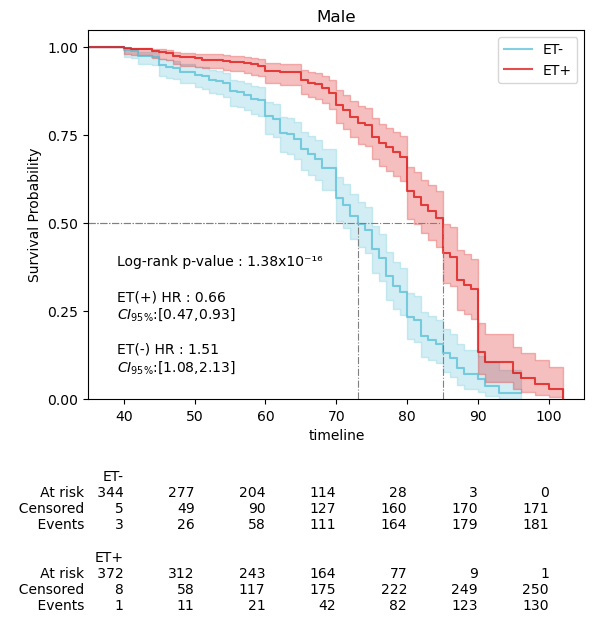

In [53]:
from lifelines import KaplanMeierFitter
from lifelines.plotting import add_at_risk_counts
from lifelines.statistics import logrank_test
import unicodeit
import numpy as np
import matplotlib.pyplot as plt

ax = plt.subplot(111)

plt.xticks(range(0, max(df["Age"]) + 10, 10))

y_ticks = [0] + [i * 0.25 for i in range(1, 5)]
plt.yticks(y_ticks)

plt.xlim([35, 105])
plt.ylim([0, 1.05])

plt.title("Male")
plt.xlabel("Age (Years)")
plt.ylabel("Survival Probability")
plt.legend(loc='best')

kmf_no_male = KaplanMeierFitter()
ax = kmf_no_male.fit(male_df[male_df["ET status"] == 0]["Age"],
                male_df[male_df["ET status"] == 0]["survival_event"], 
                label='ET-').plot_survival_function(ax=ax,color="#4DBBD5B2")

kmf_yes_male = KaplanMeierFitter()
ax = kmf_yes_male.fit(male_df[male_df["ET status"] == 1]["Age"],
                 male_df[male_df["ET status"] == 1]["survival_event"], 
                 label='ET+').plot_survival_function(ax=ax,color="#DC0000B2")

add_at_risk_counts(kmf_no_male, kmf_yes_male, ax=ax)

# Calculate and annotate median survival times
median_survival_et_male = kmf_yes_male.median_survival_time_
median_survival_non_et_male = kmf_no_male.median_survival_time_

ax.axhline(y=0.5,xmax=0.52 ,linestyle='-.', color='grey', linewidth=0.8, label='Median')
ax.axvline(x=73,ymax=0.48, linestyle='-.', color='grey', linewidth=0.8, label='Median')

ax.axhline(y=0.5,xmax=0.71 ,linestyle='-.', color='grey', linewidth=0.8, label='Median')
ax.axvline(x=85,ymax=0.48, linestyle='-.', color='grey', linewidth=0.8, label='Median')


results = logrank_test(male_df[male_df["ET status"] == 1]["Age"],
                       male_df[male_df["ET status"] == 0]["Age"], 
                       event_observed_A=male_df[male_df["ET status"] == 1]["survival_event"], 
                       event_observed_B=male_df[male_df["ET status"] == 0]["survival_event"])

number = results.p_value
exponent = int(np.floor(np.log10(np.abs(number))))
# Calculate the significand (x)
significand = number / 10**exponent
significand = round(significand,ndigits=2)
sign = '-' if exponent < 0 else ''  # Determine the sign
digits = [int(digit) for digit in str(abs(exponent))]  # Get individual digits as integers
logrank_p_value = unicodeit.replace(f"{significand}x10^{sign}^{digits[0]}^{digits[1]}")

plt.text(39, 0.38, f"Log-rank p-value : {logrank_p_value}", fontsize=10)

cph = CoxPHFitter(penalizer=0.1)
cph.fit(male_cox, duration_col='Age', event_col='survival_event')
hr = cph.hazard_ratios_
hr_sum = cph.summary

plt.text(39, 0.23, 
         f"ET(+) HR : {round(hr['Yes'], ndigits=2)}\n$CI_{{95\%}}$:[{round(hr_sum.loc['Yes', 'exp(coef) lower 95%'], ndigits=2)},{round(hr_sum.loc['Yes', 'exp(coef) upper 95%'], ndigits=2)}]",
         fontsize=10)

plt.text(39, 0.08, 
         f"ET(-) HR : {round(hr['No'], ndigits=2)}\n$CI_{{95\%}}$:[{round(hr_sum.loc['No', 'exp(coef) lower 95%'], ndigits=2)},{round(hr_sum.loc['No', 'exp(coef) upper 95%'], ndigits=2)}]",
         fontsize=10)

plt.show()

In [54]:
median_survival_et_male

85.0

In [55]:
median_survival_non_et_male

73.0

In [56]:
from lifelines.statistics import logrank_test
results = logrank_test(female_df[female_df["ET status"] == 1]["Age"],
                       female_df[female_df["ET status"] == 0]["Age"], 
                       event_observed_A=female_df[female_df["ET status"] == 1]["survival_event"], 
                       event_observed_B=female_df[female_df["ET status"] == 0]["survival_event"])

results.print_summary()
print(results.p_value)       
print(results.test_statistic) 

<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
          37.32 <0.005     29.89

1.0017980479602956e-09
37.32138958942734


In [57]:
female_cox = survival_df_expanded[survival_df_expanded["Sex"]==1]
female_cox = female_cox.drop("Sex",axis=1)
female_cox

,Age,survival_event,No,Yes
1,80,1,0,1
2,79,1,0,1
4,92,1,0,1
6,81,0,1,0
13,62,0,0,1
...,...,...,...,...
1476,43,0,0,1
1481,75,0,1,0
1483,90,1,1,0
1485,48,0,1,0


In [58]:
from lifelines import CoxPHFitter

cph = CoxPHFitter(penalizer=0.1)
cph.fit(female_cox, duration_col='Age', event_col='survival_event',formula="Yes+No")
cph.print_summary()

<lifelines.CoxPHFitter: fitted with 760 total observations, 474 right-censored observations>
             duration col = 'Age'
                event col = 'survival_event'
                penalizer = 0.1
                 l1 ratio = 0.0
      baseline estimation = breslow
   number of observations = 760
number of events observed = 286
   partial log-likelihood = -1458.85
         time fit was run = 2024-05-10 12:58:14 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
Yes        -0.32       0.73       0.17            -0.66             0.02                 0.52                 1.02
No          0.32       1.37       0.17            -0.02             0.66                 0.98                 1.93

            cmp to     z    p   -log2(p)
covariate                               
Yes           0.00 -1.85 0.06       3.94
No            0.00  1.85 0.06       3.94
---
Concordance = 0.62
Partial AIC = 2921.70
log-likelihood ratio test = 30.59 on 2 df
-log2(p) of ll-ratio test = 22.07

In [59]:
hr = cph.hazard_ratios_
hr_sum = cph.summary
print(hr[0],hr_sum)

0.7278221417318005                coef  exp(coef)  se(coef)  coef lower 95%  coef upper 95%  \
covariate                                                                  
Yes       -0.317699   0.727822  0.172156       -0.655119        0.019722   
No         0.317699   1.373962  0.172156       -0.019722        0.655119   

           exp(coef) lower 95%  exp(coef) upper 95%  cmp to         z  \
covariate                                                               
Yes                   0.519380             1.019917     0.0 -1.845408   
No                    0.980472             1.925371     0.0  1.845408   

                  p  -log2(p)  
covariate                      
Yes        0.064978    3.9439  
No         0.064978    3.9439  


/var/folders/jw/lmwzphvs71n8yhl1t4k30tzr0000gn/T/ipykernel_10811/1775232013.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(hr[0],hr_sum)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


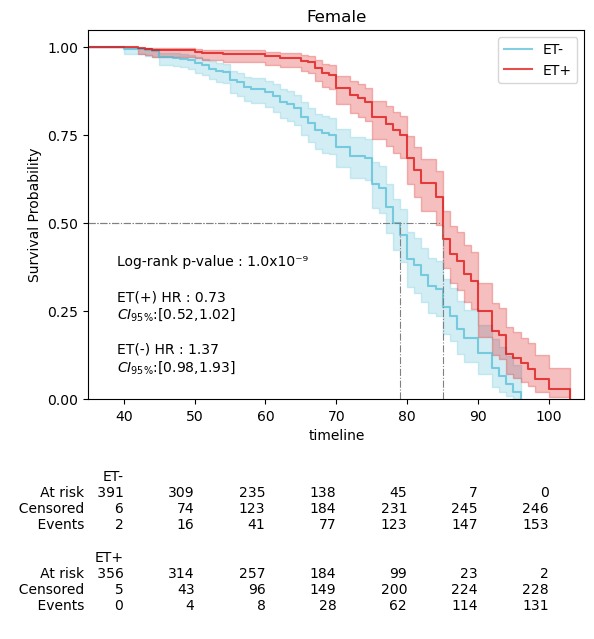

In [60]:
from lifelines import KaplanMeierFitter
from lifelines.plotting import add_at_risk_counts
from lifelines.statistics import logrank_test
import unicodeit
import numpy as np
import matplotlib.pyplot as plt

ax = plt.subplot(111)

plt.xticks(range(0, max(df["Age"]) + 10, 10))

y_ticks = [0] + [i * 0.25 for i in range(1, 5)]
plt.yticks(y_ticks)

plt.xlim([35, 105])
plt.ylim([0, 1.05])

plt.title("Female")
plt.xlabel("Age (Years)")
plt.ylabel("Survival Probability")
plt.legend(loc='best')

kmf_no_female = KaplanMeierFitter()
ax = kmf_no_female.fit(female_df[female_df["ET status"] == 0]["Age"],
                female_df[female_df["ET status"] == 0]["survival_event"], 
                label='ET-').plot_survival_function(ax=ax,color="#4DBBD5B2")

kmf_yes_female = KaplanMeierFitter()
ax = kmf_yes_female.fit(female_df[female_df["ET status"] == 1]["Age"],
                 female_df[female_df["ET status"] == 1]["survival_event"], 
                 label='ET+').plot_survival_function(ax=ax,color="#DC0000B2")

add_at_risk_counts(kmf_no_female, kmf_yes_female, ax=ax)

# Calculate and annotate median survival times
median_survival_et_female = kmf_yes_female.median_survival_time_
median_survival_non_et_female = kmf_no_female.median_survival_time_

ax.axhline(y=0.5,xmax=0.52 ,linestyle='-.', color='grey', linewidth=0.8, label='Median')
ax.axvline(x=79,ymax=0.48, linestyle='-.', color='grey', linewidth=0.8, label='Median')

ax.axhline(y=0.5,xmax=0.71 ,linestyle='-.', color='grey', linewidth=0.8, label='Median')
ax.axvline(x=85,ymax=0.48, linestyle='-.', color='grey', linewidth=0.8, label='Median')


results = logrank_test(female_df[female_df["ET status"] == 1]["Age"],
                       female_df[female_df["ET status"] == 0]["Age"], 
                       event_observed_A=female_df[female_df["ET status"] == 1]["survival_event"], 
                       event_observed_B=female_df[female_df["ET status"] == 0]["survival_event"])

number = results.p_value
exponent = int(np.floor(np.log10(np.abs(number))))
# Calculate the significand (x)
significand = number / 10**exponent
significand = round(significand,ndigits=2)
sign = '-' if exponent < 0 else ''  # Determine the sign
digits = [int(digit) for digit in str(abs(exponent))]  # Get individual digits as integers
logrank_p_value = unicodeit.replace(f"{significand}x10^{sign}^{digits[0]}")

plt.text(39, 0.38, f"Log-rank p-value : {logrank_p_value}", fontsize=10)

cph = CoxPHFitter(penalizer=0.1)
cph.fit(female_cox, duration_col='Age', event_col='survival_event')
hr = cph.hazard_ratios_
hr_sum = cph.summary

plt.text(39, 0.23, 
         f"ET(+) HR : {round(hr['Yes'], ndigits=2)}\n$CI_{{95\%}}$:[{round(hr_sum.loc['Yes', 'exp(coef) lower 95%'], ndigits=2)},{round(hr_sum.loc['Yes', 'exp(coef) upper 95%'], ndigits=2)}]",
         fontsize=10)

plt.text(39, 0.08, 
         f"ET(-) HR : {round(hr['No'], ndigits=2)}\n$CI_{{95\%}}$:[{round(hr_sum.loc['No', 'exp(coef) lower 95%'], ndigits=2)},{round(hr_sum.loc['No', 'exp(coef) upper 95%'], ndigits=2)}]",
         fontsize=10)

plt.show()

In [61]:
median_survival_et_female

85.0

In [62]:
median_survival_non_et_female

79.0

In [63]:
survival_df_60 = survival_df[survival_df["Age"]>59]
survival_df_60

,Age,Sex,ET status,survival_event
0,75,2,0,1
1,80,1,1,1
2,79,1,1,1
3,70,2,0,1
4,92,1,1,1
...,...,...,...,...
1479,76,2,0,1
1480,77,2,0,0
1481,75,1,0,0
1482,78,2,0,0


In [64]:
min(survival_df_60["Age"])

60

In [65]:
from lifelines.statistics import logrank_test
results = logrank_test(survival_df_60[survival_df_60["ET status"] == 0]["Age"],
                       survival_df_60[survival_df_60["ET status"] == 1]["Age"], 
                       event_observed_A=survival_df_60[survival_df_60["ET status"] == 0]["survival_event"], 
                       event_observed_B=survival_df_60[survival_df_60["ET status"] == 1]["survival_event"])

results.print_summary()
print(results.p_value)       
print(results.test_statistic) 

<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
          65.68 <0.005     50.75

5.29301036254374e-16
65.68413992793894


In [66]:
from lifelines import CoxPHFitter

cph = CoxPHFitter()
cph.fit(survival_df_60[["Age","survival_event","ET status"]], duration_col='Age', event_col='survival_event')
cph.print_summary()

<lifelines.CoxPHFitter: fitted with 983 total observations, 492 right-censored observations>
             duration col = 'Age'
                event col = 'survival_event'
      baseline estimation = breslow
   number of observations = 983
number of events observed = 491
   partial log-likelihood = -2750.36
         time fit was run = 2024-05-10 12:58:15 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
ET status  -0.73       0.48       0.09            -0.91            -0.54                 0.40                 0.58

            cmp to     z      p   -log2(p)
covariate                                 
ET status     0.00 -7.80 <0.005      47.25
---
Concordance = 0.61
Partial AIC = 5502.73
log-likelihood ratio test = 60.34 on 1 df
-log2(p) of ll-ratio test = 46.83

In [67]:
hr = cph.hazard_ratios_
hr_ci = cph.confidence_intervals_
print(hr[0],hr_ci)

0.4833243626284849            95% lower-bound  95% upper-bound
covariate                                  
ET status        -0.909651        -0.544484


/var/folders/jw/lmwzphvs71n8yhl1t4k30tzr0000gn/T/ipykernel_10811/3387008977.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(hr[0],hr_ci)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/var/folders/jw/lmwzphvs71n8yhl1t4k30tzr0000gn/T/ipykernel_10811/1387449133.py:70: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  f"HR : {round(hr[0],ndigits=2)}\n$CI_{{95\%}}:$[{round(hr_ci.loc['ET status', '95% lower-bound'],ndigits=2)},{round(hr_ci.loc['ET status', '95% upper-bound'],ndigits=2)}]",


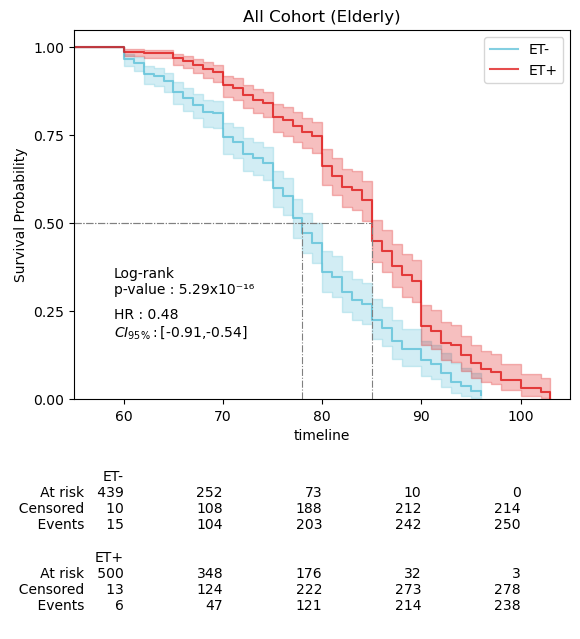

In [68]:
from lifelines import KaplanMeierFitter
from lifelines.plotting import add_at_risk_counts
from lifelines.statistics import logrank_test
import unicodeit
import numpy as np
import matplotlib.pyplot as plt

ax = plt.subplot(111)

plt.xticks(range(0, max(df["Age"]) + 10, 10))

y_ticks = [0] + [i * 0.25 for i in range(1, 5)]
plt.yticks(y_ticks)

plt.xlim([55, 105])
plt.ylim([0, 1.05])

plt.title("All Cohort (Elderly)")
plt.xlabel("Age (Years)")
plt.ylabel("Survival Probability")
plt.legend(loc='best')

kmf_no = KaplanMeierFitter()
ax = kmf_no.fit(survival_df_60[survival_df_60["ET status"] == 0]["Age"],
                survival_df_60[survival_df_60["ET status"] == 0]["survival_event"], 
                label='ET-').plot_survival_function(ax=ax,color="#4DBBD5B2")

kmf_yes = KaplanMeierFitter()
ax = kmf_yes.fit(survival_df_60[survival_df_60["ET status"] == 1]["Age"],
                 survival_df_60[survival_df_60["ET status"] == 1]["survival_event"], 
                 label='ET+').plot_survival_function(ax=ax,color="#DC0000B2")

add_at_risk_counts(kmf_no, kmf_yes, ax=ax)

# Calculate and annotate median survival times
median_survival_et = kmf_yes.median_survival_time_
median_survival_non_et = kmf_no.median_survival_time_

ax.axhline(y=0.5,xmax=0.5 ,linestyle='-.', color='grey', linewidth=0.8, label='Median')
ax.axvline(x=78,ymax=0.48, linestyle='-.', color='grey', linewidth=0.8, label='Median')

ax.axhline(y=0.5,xmax=0.6 ,linestyle='-.', color='grey', linewidth=0.8, label='Median')
ax.axvline(x=85,ymax=0.48, linestyle='-.', color='grey', linewidth=0.8, label='Median')


results = logrank_test(survival_df_60[survival_df_60["ET status"] == 0]["Age"],
                       survival_df_60[survival_df_60["ET status"] == 1]["Age"], 
                       event_observed_A=survival_df_60[survival_df_60["ET status"] == 0]["survival_event"], 
                       event_observed_B=survival_df_60[survival_df_60["ET status"] == 1]["survival_event"])

number = results.p_value
exponent = int(np.floor(np.log10(np.abs(number))))
# Calculate the significand (x)
significand = number / 10**exponent
significand = round(significand,ndigits=2)
sign = '-' if exponent < 0 else ''  # Determine the sign
digits = [int(digit) for digit in str(abs(exponent))]  # Get individual digits as integers
logrank_p_value = unicodeit.replace(f"{significand}x10^{sign}^{digits[0]}^{digits[1]}")

plt.text(59, 0.3, f"Log-rank\np-value : {logrank_p_value}", fontsize=10)

from lifelines import CoxPHFitter

cph = CoxPHFitter()
cph.fit(survival_df_60[["Age","survival_event","ET status"]], duration_col='Age', event_col='survival_event')
hr = cph.hazard_ratios_
hr_ci = cph.confidence_intervals_

plt.text(59, 0.18, 
         f"HR : {round(hr[0],ndigits=2)}\n$CI_{{95\%}}:$[{round(hr_ci.loc['ET status', '95% lower-bound'],ndigits=2)},{round(hr_ci.loc['ET status', '95% upper-bound'],ndigits=2)}]", 
         fontsize=10)

plt.show()

In [69]:
median_survival_et

85.0

In [70]:
median_survival_non_et

78.0

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/var/folders/jw/lmwzphvs71n8yhl1t4k30tzr0000gn/T/ipykernel_10811/1825479617.py:73: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  f"HR : {round(hr[0],ndigits=2)}, $CI_{{95\%}}:$[{round(hr_sum.loc['ET status', 'exp(coef) lower 95%'],ndigits=2)},{round(hr_sum.loc['ET status', 'exp(coef) upper 95%'],ndigits=2)}]",
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/var/folders/jw/lmwzphvs71n8yhl1t4k30tzr0000gn/T/ipykernel_10811/1825479617.py:143: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integ

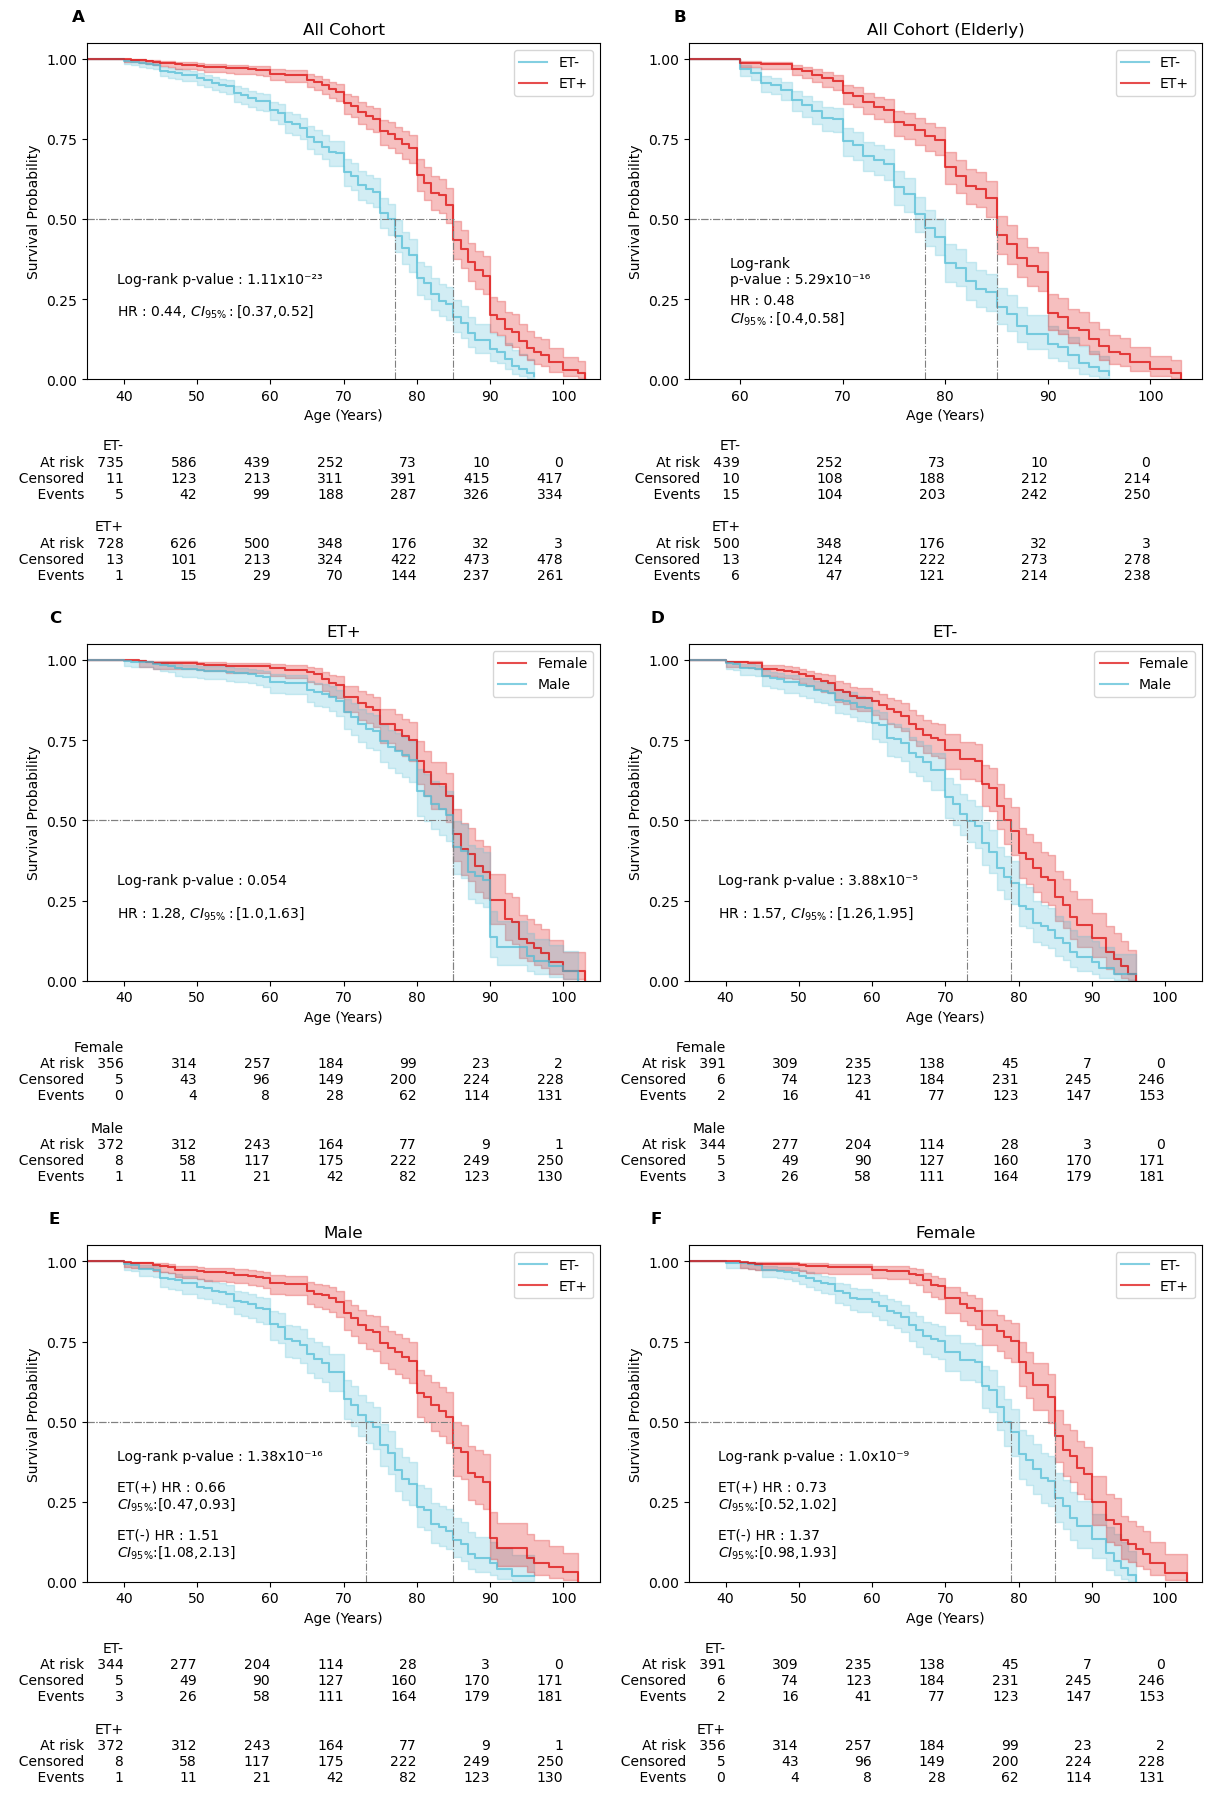

In [75]:
from matplotlib.gridspec import GridSpec

fig = plt.figure(layout="constrained",figsize=(12,18))

gs = GridSpec(3, 2, figure=fig)

# All Cohort
ax = fig.add_subplot(gs[0, 0])

plt.xticks(range(0, max(df["Age"]) + 10, 10))

y_ticks = [0] + [i * 0.25 for i in range(1, 5)]
plt.yticks(y_ticks)

plt.xlim([35, 105])
plt.ylim([0, 1.05])

plt.title("All Cohort")

plt.ylabel("Survival Probability")
plt.legend(loc='best')

ax.text(-0.03, 1.1, "A", transform=ax.transAxes, fontsize=12, fontweight='bold', va='top')

kmf_no = KaplanMeierFitter()
ax = kmf_no.fit(survival_df[survival_df["ET status"] == 0]["Age"],
                survival_df[survival_df["ET status"] == 0]["survival_event"], 
                label='ET-').plot_survival_function(ax=ax,color="#4DBBD5B2")

kmf_yes = KaplanMeierFitter()
ax = kmf_yes.fit(survival_df[survival_df["ET status"] == 1]["Age"],
                 survival_df[survival_df["ET status"] == 1]["survival_event"], 
                 label='ET+').plot_survival_function(ax=ax,color="#DC0000B2")

add_at_risk_counts(kmf_no, kmf_yes, ax=ax)

# Calculate and annotate median survival times
median_survival_et = kmf_yes.median_survival_time_
median_survival_non_et = kmf_no.median_survival_time_

ax.axhline(y=0.5,xmax=0.52 ,linestyle='-.', color='grey', linewidth=0.8, label='Median')
ax.axvline(x=77,ymax=0.48, linestyle='-.', color='grey', linewidth=0.8, label='Median')

ax.axhline(y=0.5,xmax=0.715 ,linestyle='-.', color='grey', linewidth=0.8, label='Median')
ax.axvline(x=85,ymax=0.48, linestyle='-.', color='grey', linewidth=0.8, label='Median')


results = logrank_test(survival_df[survival_df["ET status"] == 0]["Age"],
                       survival_df[survival_df["ET status"] == 1]["Age"], 
                       event_observed_A=survival_df[survival_df["ET status"] == 0]["survival_event"], 
                       event_observed_B=survival_df[survival_df["ET status"] == 1]["survival_event"])

number = results.p_value
exponent = int(np.floor(np.log10(np.abs(number))))
# Calculate the significand (x)
significand = number / 10**exponent
significand = round(significand,ndigits=2)
sign = '-' if exponent < 0 else ''  # Determine the sign
digits = [int(digit) for digit in str(abs(exponent))]  # Get individual digits as integers
logrank_p_value = unicodeit.replace(f"{significand}x10^{sign}^{digits[0]}^{digits[1]}")

plt.text(39, 0.3, f"Log-rank p-value : {logrank_p_value}", fontsize=10)


from lifelines import CoxPHFitter

cph = CoxPHFitter()
cph.fit(survival_df[["Age","survival_event","ET status"]], duration_col='Age', event_col='survival_event')
hr = cph.hazard_ratios_
hr_sum = cph.summary

plt.text(39, 0.2, 
         f"HR : {round(hr[0],ndigits=2)}, $CI_{{95\%}}:$[{round(hr_sum.loc['ET status', 'exp(coef) lower 95%'],ndigits=2)},{round(hr_sum.loc['ET status', 'exp(coef) upper 95%'],ndigits=2)}]", 
         fontsize=10)
ax.set_xlabel("Age (Years)")

# Elderly Cohort
ax = fig.add_subplot(gs[0, 1])

plt.xticks(range(0, max(df["Age"]) + 10, 10))

y_ticks = [0] + [i * 0.25 for i in range(1, 5)]
plt.yticks(y_ticks)

plt.xlim([55, 105])
plt.ylim([0, 1.05])

plt.title("All Cohort (Elderly)")
plt.xlabel("Age (Years)")
plt.ylabel("Survival Probability")
plt.legend(loc='best')

ax.text(-0.03, 1.1, "B", transform=ax.transAxes, fontsize=12, fontweight='bold', va='top')

kmf_no = KaplanMeierFitter()
ax = kmf_no.fit(survival_df_60[survival_df_60["ET status"] == 0]["Age"],
                survival_df_60[survival_df_60["ET status"] == 0]["survival_event"], 
                label='ET-').plot_survival_function(ax=ax,color="#4DBBD5B2")

kmf_yes = KaplanMeierFitter()
ax = kmf_yes.fit(survival_df_60[survival_df_60["ET status"] == 1]["Age"],
                 survival_df_60[survival_df_60["ET status"] == 1]["survival_event"], 
                 label='ET+').plot_survival_function(ax=ax,color="#DC0000B2")

add_at_risk_counts(kmf_no, kmf_yes, ax=ax)

# Calculate and annotate median survival times
median_survival_et = kmf_yes.median_survival_time_
median_survival_non_et = kmf_no.median_survival_time_

ax.axhline(y=0.5,xmax=0.5 ,linestyle='-.', color='grey', linewidth=0.8, label='Median')
ax.axvline(x=78,ymax=0.48, linestyle='-.', color='grey', linewidth=0.8, label='Median')

ax.axhline(y=0.5,xmax=0.6 ,linestyle='-.', color='grey', linewidth=0.8, label='Median')
ax.axvline(x=85,ymax=0.48, linestyle='-.', color='grey', linewidth=0.8, label='Median')


results = logrank_test(survival_df_60[survival_df_60["ET status"] == 0]["Age"],
                       survival_df_60[survival_df_60["ET status"] == 1]["Age"], 
                       event_observed_A=survival_df_60[survival_df_60["ET status"] == 0]["survival_event"], 
                       event_observed_B=survival_df_60[survival_df_60["ET status"] == 1]["survival_event"])

number = results.p_value
exponent = int(np.floor(np.log10(np.abs(number))))
# Calculate the significand (x)
significand = number / 10**exponent
significand = round(significand,ndigits=2)
sign = '-' if exponent < 0 else ''  # Determine the sign
digits = [int(digit) for digit in str(abs(exponent))]  # Get individual digits as integers
logrank_p_value = unicodeit.replace(f"{significand}x10^{sign}^{digits[0]}^{digits[1]}")

plt.text(59, 0.3, f"Log-rank\np-value : {logrank_p_value}", fontsize=10)
ax.set_xlabel("Age (Years)")

from lifelines import CoxPHFitter

cph = CoxPHFitter()
cph.fit(survival_df_60[["Age","survival_event","ET status"]], duration_col='Age', event_col='survival_event')
hr = cph.hazard_ratios_
hr_sum = cph.summary

plt.text(59, 0.18, 
         f"HR : {round(hr[0],ndigits=2)}\n$CI_{{95\%}}:$[{round(hr_sum.loc['ET status', 'exp(coef) lower 95%'],ndigits=2)},{round(hr_sum.loc['ET status', 'exp(coef) upper 95%'],ndigits=2)}]", 
         fontsize=10)

# ET+
ax = fig.add_subplot(gs[1, 0])
plt.xticks(range(0, max(df["Age"]) + 10, 10))

y_ticks = [0] + [i * 0.25 for i in range(1, 5)]
plt.yticks(y_ticks)

plt.xlim([35, 105])
plt.ylim([0, 1.05])

plt.title("ET+")

plt.ylabel("Survival Probability")
plt.legend(loc='best')

ax.text(-0.075, 1.1, "C", transform=ax.transAxes, fontsize=12, fontweight='bold', va='top')

kmf_female = KaplanMeierFitter()
ax = kmf_female.fit(et_positive_df[et_positive_df["Sex"] == 1]["Age"],
                et_positive_df[et_positive_df["Sex"] == 1]["survival_event"], 
                label='Female').plot_survival_function(ax=ax,color="#DC0000B2")

kmf_male = KaplanMeierFitter()
ax = kmf_male.fit(et_positive_df[et_positive_df["Sex"] == 2]["Age"],
                 et_positive_df[et_positive_df["Sex"] == 2]["survival_event"], 
                 label='Male').plot_survival_function(ax=ax,color="#4DBBD5B2")

add_at_risk_counts(kmf_female, kmf_male, ax=ax)

# Calculate and annotate median survival times
median_survival_female = kmf_female.median_survival_time_
median_survival_male = kmf_male.median_survival_time_

ax.axhline(y=0.5,xmax=0.52 ,linestyle='-.', color='grey', linewidth=0.8, label='Median')
ax.axvline(x=85,ymax=0.48, linestyle='-.', color='grey', linewidth=0.8, label='Median')

ax.axhline(y=0.5,xmax=0.71 ,linestyle='-.', color='grey', linewidth=0.8, label='Median')
ax.axvline(x=85,ymax=0.48, linestyle='-.', color='grey', linewidth=0.8, label='Median')


results = logrank_test(et_positive_df[et_positive_df["Sex"] == 1]["Age"],
                       et_positive_df[et_positive_df["Sex"] == 2]["Age"], 
                       event_observed_A=et_positive_df[et_positive_df["Sex"] == 1]["survival_event"], 
                       event_observed_B=et_positive_df[et_positive_df["Sex"] == 2]["survival_event"])


logrank_p_value = round(results.p_value,ndigits=3)

plt.text(39, 0.3, f"Log-rank p-value : {logrank_p_value}", fontsize=10)

from lifelines import CoxPHFitter

cph = CoxPHFitter()
cph.fit(et_positive_cox, duration_col='Age', event_col='survival_event')
hr = cph.hazard_ratios_
hr_sum = cph.summary

plt.text(39, 0.2, 
         f"HR : {round(hr[0],ndigits=2)}, $CI_{{95\%}}:$[{round(hr_sum.loc['Sex', 'exp(coef) lower 95%'],ndigits=2)},{round(hr_sum.loc['Sex', 'exp(coef) upper 95%'],ndigits=2)}]", 
         fontsize=10)
ax.set_xlabel("Age (Years)")

# ET-
ax = fig.add_subplot(gs[1, 1])
plt.xticks(range(0, max(df["Age"]) + 10, 10))

y_ticks = [0] + [i * 0.25 for i in range(1, 5)]
plt.yticks(y_ticks)

plt.xlim([35, 105])
plt.ylim([0, 1.05])

plt.title("ET-")

plt.ylabel("Survival Probability")
plt.legend(loc='best')

ax.text(-0.075, 1.1, "D", transform=ax.transAxes, fontsize=12, fontweight='bold', va='top')

kmf_female = KaplanMeierFitter()
ax = kmf_female.fit(et_negative_df[et_negative_df["Sex"] == 1]["Age"],
                et_negative_df[et_negative_df["Sex"] == 1]["survival_event"], 
                label='Female').plot_survival_function(ax=ax,color="#DC0000B2")

kmf_male = KaplanMeierFitter()
ax = kmf_male.fit(et_negative_df[et_negative_df["Sex"] == 2]["Age"],
                 et_negative_df[et_negative_df["Sex"] == 2]["survival_event"], 
                 label='Male').plot_survival_function(ax=ax,color="#4DBBD5B2")

add_at_risk_counts(kmf_female, kmf_male, ax=ax)

# Calculate and annotate median survival times
median_survival_female = kmf_female.median_survival_time_
median_survival_male = kmf_male.median_survival_time_

ax.axhline(y=0.5,xmax=0.45 ,linestyle='-.', color='grey', linewidth=0.8, label='Median')
ax.axvline(x=79,ymax=0.48, linestyle='-.', color='grey', linewidth=0.8, label='Median')

ax.axhline(y=0.5,xmax=0.62 ,linestyle='-.', color='grey', linewidth=0.8, label='Median')
ax.axvline(x=73,ymax=0.48, linestyle='-.', color='grey', linewidth=0.8, label='Median')


results = logrank_test(et_negative_df[et_negative_df["Sex"] == 1]["Age"],
                       et_negative_df[et_negative_df["Sex"] == 2]["Age"], 
                       event_observed_A=et_negative_df[et_negative_df["Sex"] == 1]["survival_event"], 
                       event_observed_B=et_negative_df[et_negative_df["Sex"] == 2]["survival_event"])

number = results.p_value
exponent = int(np.floor(np.log10(np.abs(number))))
# Calculate the significand (x)
significand = number / 10**exponent
significand = round(significand,ndigits=2)
sign = '-' if exponent < 0 else ''  # Determine the sign
digits = [int(digit) for digit in str(abs(exponent))]  # Get individual digits as integers
logrank_p_value = unicodeit.replace(f"{significand}x10^{sign}^{digits[0]}")

plt.text(39, 0.3, f"Log-rank p-value : {logrank_p_value}", fontsize=10)

cph = CoxPHFitter()
cph.fit(et_negative_df[["Age","Sex","survival_event"]], duration_col='Age', event_col='survival_event')
hr = cph.hazard_ratios_
hr_sum = cph.summary

plt.text(39, 0.2, 
         f"HR : {round(hr[0],ndigits=2)}, $CI_{{95\%}}:$[{round(hr_sum.loc['Sex', 'exp(coef) lower 95%'],ndigits=2)},{round(hr_sum.loc['Sex', 'exp(coef) upper 95%'],ndigits=2)}]", 
         fontsize=10)
ax.set_xlabel("Age (Years)")

# Male
ax = fig.add_subplot(gs[2, 0])
plt.xticks(range(0, max(df["Age"]) + 10, 10))

y_ticks = [0] + [i * 0.25 for i in range(1, 5)]
plt.yticks(y_ticks)

plt.xlim([35, 105])
plt.ylim([0, 1.05])

plt.title("Male")

plt.ylabel("Survival Probability")
plt.legend(loc='best')

ax.text(-0.075, 1.1, "E", transform=ax.transAxes, fontsize=12, fontweight='bold', va='top')

kmf_no_male = KaplanMeierFitter()
ax = kmf_no_male.fit(male_df[male_df["ET status"] == 0]["Age"],
                male_df[male_df["ET status"] == 0]["survival_event"], 
                label='ET-').plot_survival_function(ax=ax,color="#4DBBD5B2")

kmf_yes_male = KaplanMeierFitter()
ax = kmf_yes_male.fit(male_df[male_df["ET status"] == 1]["Age"],
                 male_df[male_df["ET status"] == 1]["survival_event"], 
                 label='ET+').plot_survival_function(ax=ax,color="#DC0000B2")

add_at_risk_counts(kmf_no_male, kmf_yes_male, ax=ax)

# Calculate and annotate median survival times
median_survival_et_male = kmf_yes_male.median_survival_time_
median_survival_non_et_male = kmf_no_male.median_survival_time_

ax.axhline(y=0.5,xmax=0.52 ,linestyle='-.', color='grey', linewidth=0.8, label='Median')
ax.axvline(x=73,ymax=0.48, linestyle='-.', color='grey', linewidth=0.8, label='Median')

ax.axhline(y=0.5,xmax=0.71 ,linestyle='-.', color='grey', linewidth=0.8, label='Median')
ax.axvline(x=85,ymax=0.48, linestyle='-.', color='grey', linewidth=0.8, label='Median')


results = logrank_test(male_df[male_df["ET status"] == 1]["Age"],
                       male_df[male_df["ET status"] == 0]["Age"], 
                       event_observed_A=male_df[male_df["ET status"] == 1]["survival_event"], 
                       event_observed_B=male_df[male_df["ET status"] == 0]["survival_event"])

number = results.p_value
exponent = int(np.floor(np.log10(np.abs(number))))
# Calculate the significand (x)
significand = number / 10**exponent
significand = round(significand,ndigits=2)
sign = '-' if exponent < 0 else ''  # Determine the sign
digits = [int(digit) for digit in str(abs(exponent))]  # Get individual digits as integers
logrank_p_value = unicodeit.replace(f"{significand}x10^{sign}^{digits[0]}^{digits[1]}")

plt.text(39, 0.38, f"Log-rank p-value : {logrank_p_value}", fontsize=10)

cph = CoxPHFitter(penalizer=0.1)
cph.fit(male_cox, duration_col='Age', event_col='survival_event')
hr = cph.hazard_ratios_
hr_sum = cph.summary

plt.text(39, 0.23, 
         f"ET(+) HR : {round(hr['Yes'], ndigits=2)}\n$CI_{{95\%}}$:[{round(hr_sum.loc['Yes', 'exp(coef) lower 95%'], ndigits=2)},{round(hr_sum.loc['Yes', 'exp(coef) upper 95%'], ndigits=2)}]",
         fontsize=10)

plt.text(39, 0.08, 
         f"ET(-) HR : {round(hr['No'], ndigits=2)}\n$CI_{{95\%}}$:[{round(hr_sum.loc['No', 'exp(coef) lower 95%'], ndigits=2)},{round(hr_sum.loc['No', 'exp(coef) upper 95%'], ndigits=2)}]",
         fontsize=10)
ax.set_xlabel("Age (Years)")

# Female
ax = fig.add_subplot(gs[2, 1])
plt.xticks(range(0, max(df["Age"]) + 10, 10))

y_ticks = [0] + [i * 0.25 for i in range(1, 5)]
plt.yticks(y_ticks)

plt.xlim([35, 105])
plt.ylim([0, 1.05])

plt.title("Female")

plt.ylabel("Survival Probability")
plt.legend(loc='best')

ax.text(-0.075, 1.1, "F", transform=ax.transAxes, fontsize=12, fontweight='bold', va='top')

kmf_no_female = KaplanMeierFitter()
ax = kmf_no_female.fit(female_df[female_df["ET status"] == 0]["Age"],
                female_df[female_df["ET status"] == 0]["survival_event"], 
                label='ET-').plot_survival_function(ax=ax,color="#4DBBD5B2")

kmf_yes_female = KaplanMeierFitter()
ax = kmf_yes_female.fit(female_df[female_df["ET status"] == 1]["Age"],
                 female_df[female_df["ET status"] == 1]["survival_event"], 
                 label='ET+').plot_survival_function(ax=ax,color="#DC0000B2")

add_at_risk_counts(kmf_no_female, kmf_yes_female, ax=ax)

# Calculate and annotate median survival times
median_survival_et_female = kmf_yes_female.median_survival_time_
median_survival_non_et_female = kmf_no_female.median_survival_time_

ax.axhline(y=0.5,xmax=0.52 ,linestyle='-.', color='grey', linewidth=0.8, label='Median')
ax.axvline(x=79,ymax=0.48, linestyle='-.', color='grey', linewidth=0.8, label='Median')

ax.axhline(y=0.5,xmax=0.71 ,linestyle='-.', color='grey', linewidth=0.8, label='Median')
ax.axvline(x=85,ymax=0.48, linestyle='-.', color='grey', linewidth=0.8, label='Median')


results = logrank_test(female_df[female_df["ET status"] == 1]["Age"],
                       female_df[female_df["ET status"] == 0]["Age"], 
                       event_observed_A=female_df[female_df["ET status"] == 1]["survival_event"], 
                       event_observed_B=female_df[female_df["ET status"] == 0]["survival_event"])

number = results.p_value
exponent = int(np.floor(np.log10(np.abs(number))))
# Calculate the significand (x)
significand = number / 10**exponent
significand = round(significand,ndigits=2)
sign = '-' if exponent < 0 else ''  # Determine the sign
digits = [int(digit) for digit in str(abs(exponent))]  # Get individual digits as integers
logrank_p_value = unicodeit.replace(f"{significand}x10^{sign}^{digits[0]}")

plt.text(39, 0.38, f"Log-rank p-value : {logrank_p_value}", fontsize=10)

cph = CoxPHFitter(penalizer=0.1)
cph.fit(female_cox, duration_col='Age', event_col='survival_event')
hr = cph.hazard_ratios_
hr_sum = cph.summary

plt.text(39, 0.23, 
         f"ET(+) HR : {round(hr['Yes'], ndigits=2)}\n$CI_{{95\%}}$:[{round(hr_sum.loc['Yes', 'exp(coef) lower 95%'], ndigits=2)},{round(hr_sum.loc['Yes', 'exp(coef) upper 95%'], ndigits=2)}]",
         fontsize=10)

plt.text(39, 0.08, 
         f"ET(-) HR : {round(hr['No'], ndigits=2)}\n$CI_{{95\%}}$:[{round(hr_sum.loc['No', 'exp(coef) lower 95%'], ndigits=2)},{round(hr_sum.loc['No', 'exp(coef) upper 95%'], ndigits=2)}]",
         fontsize=10)
ax.set_xlabel("Age (Years)")
#fig.suptitle("Survival Analaysis")
plt.savefig('survival_python.png', dpi=300, bbox_inches='tight')
plt.savefig('survival_python.tiff', dpi=300, bbox_inches='tight',pil_kwargs={"compression": "tiff_lzw"})
plt.show()

In [72]:
import sys
sys.version_info

sys.version_info(major=3, minor=11, micro=5, releaselevel='final', serial=0)

In [73]:
!pip freeze

absl-py==1.4.0
aiobotocore @ file:///private/var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_71xswk40o_/croot/aiobotocore_1682537536268/work
aiodns==2.0.0
aiofiles @ file:///private/var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_f56ag8l7kr/croot/aiofiles_1683773599608/work
aiohttp @ file:///private/var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_6fjtz5frfh/croot/aiohttp_1701112546765/work
aioitertools @ file:///tmp/build/80754af9/aioitertools_1607109665762/work
aiosignal @ file:///tmp/build/80754af9/aiosignal_1637843061372/work
aiosqlite @ file:///private/var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_3d75lecab1/croot/aiosqlite_1683773918307/work
alabaster @ file:///home/ktietz/src/ci/alabaster_1611921544520/work
anaconda-anon-usage @ file:///private/var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_ca68ugx5h9/croot/anaconda-anon-usage_1697038938120/work
anaconda-catalogs @ file:///private/var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_e8tmw882qa/croot/anaconda

Pillow @ file:///private/var/folders/k1/30mswbxs7r1g6zwn8y4fyt500000gp/T/abs_ccx0_h9rkg/croot/pillow_1696580032390/work
pingouin==0.5.3
pipdeptree==2.12.0
pkce @ file:///private/var/folders/k1/30mswbxs7r1g6zwn8y4fyt500000gp/T/abs_da285fiplp/croot/pkce_1690384839054/work
pkginfo @ file:///private/var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_d1oq9rhye6/croot/pkginfo_1679431178842/work
platformdirs @ file:///private/var/folders/k1/30mswbxs7r1g6zwn8y4fyt500000gp/T/abs_a8u4fy8k9o/croot/platformdirs_1692205661656/work
plotly @ file:///Users/cbousseau/work/recipes/ci_py311/plotly_1677953301864/work
pluggy @ file:///Users/cbousseau/work/recipes/ci_py311/pluggy_1677906980825/work
ply==3.11
Pmw==2.1.1
portalocker==2.8.2
poyo @ file:///tmp/build/80754af9/poyo_1617751526755/work
prometheus-client @ file:///Users/cbousseau/work/recipes/ci_py311_2/prometheus_client_1678996808082/work
prompt-toolkit @ file:///Users/cbousseau/work/recipes/ci_py311/prompt-toolkit_1677918689663/work
Protego @ fil